In [1]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas as pd
import rasterio
import matplotlib.pyplot as plt

In [2]:
crta_coords = pd.read_csv('calculate_aoo/df2csv/cornuta_all.csv')
crta_coords = crta_coords[(crta_coords['lat']>0) & (crta_coords['long']>-20)]
print(f'lat_min = {crta_coords['lat'].min()}\nlat_max = {crta_coords['lat'].max()}\nlon_min = {crta_coords['long'].min()}\nlat_max = {crta_coords['long'].max()}\n')

lat_min = 34.9625
lat_max = 59.918117
lon_min = -7.537369
lat_max = 51.08368



In [3]:
bbox = [-8, 35, 52, 60] #minx, miny, maxx, maxy

num_points_side = int(np.sqrt(5000))  
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points)

shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

land_points = grid_gdf[grid_gdf['geometry'].apply(lambda point:gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
land_coordinates = [(point.y, point.x) for point in land_points['geometry']]

lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

(-10.99999999999996, 52.9999999999998, 33.99999999999987, 69.03428709808546)

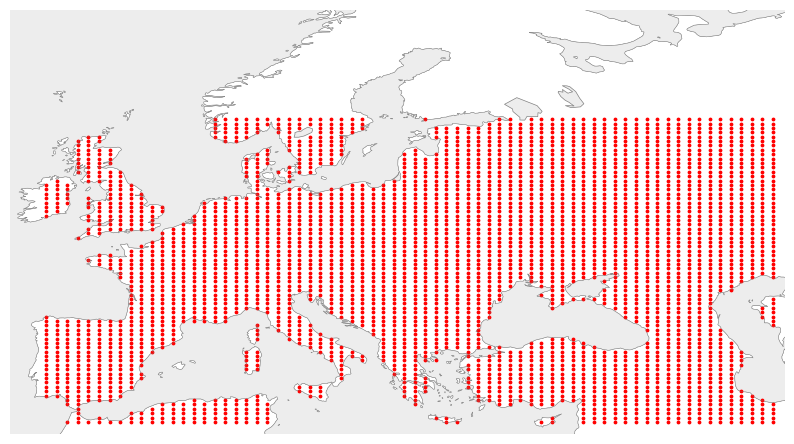

In [4]:

plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax = plt.gca()
ax.set_extent([-11, 53, 34,  66])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

#ndvi_tiff_path = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio/NDVI_hires.tif'
#with rasterio.open(ndvi_tiff_path) as ndvi_src:
#   ndvi_data = ndvi_src.read(1)
#    vmin, vmax = ndvi_data.min(), ndvi_data.max()

#    plt.imshow(ndvi_data, vmin=-1, vmax=1, origin='upper', transform=ccrs.PlateCarree(), cmap='twilight_shifted')

lats, lons = zip(*land_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='o', color='red', s=3)
ax.axis('off')

# cbar = plt.colorbar(label='NDVI', fraction=0.03, pad=0.04)
# cbar.set_label('NDVI') , extent=[-127, -64.5, 34, 55]

In [5]:
europe_df = pd.DataFrame(land_coordinates, columns=['lat', 'lon'])

In [6]:
import os
from concurrent.futures import ThreadPoolExecutor


def get_value_from_array(lat, long, src, array):
    try:
        row, col = src.index(long, lat)
        return array[row, col]
    except Exception as e:
        print(f'Error at {lat}, {long}: {e}')
        return None
    
ndvi_tiff_path = 'data/tifs/NDVI_Image.tif'
all_files = [ndvi_tiff_path]

print(all_files)

def process_file(file):
    column_name = 'ndvi'
    print(f'Processing: {column_name}\n')

    with rasterio.open(file) as src:
        array = src.read(1)  
        europe_df[column_name] = europe_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=1) as executor: 
    executor.map(process_file, all_files)

directory = 'data/wc2.1_30s_bio'
all_files = [f for f in os.listdir(directory) if f.endswith('.tif') and "wc2.1_30s_" in f]

print(all_files)

def process_file(file):
    column_name = file.split("wc2.1_30s_")[1].replace(".tif", "")
    file_path = os.path.join(directory, file)
    print(f'Processing: {column_name}\n')

    with rasterio.open(file_path) as src:
        array = src.read(1)  
        europe_df[column_name] = europe_df.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

with ThreadPoolExecutor(max_workers=4) as executor:  
    executor.map(process_file, all_files)

# america_df.to_csv('america_bioclim_ndvi.csv')


['data/tifs/NDVI_Image.tif']
Processing: ndvi

['wc2.1_30s_bio_11.tif', 'wc2.1_30s_bio_3.tif', 'wc2.1_30s_bio_9.tif', 'wc2.1_30s_bio_13.tif', 'wc2.1_30s_bio_5.tif', 'wc2.1_30s_bio_6.tif', 'wc2.1_30s_elev.tif', 'wc2.1_30s_bio_17.tif', 'wc2.1_30s_bio_10.tif', 'wc2.1_30s_bio_2.tif', 'wc2.1_30s_bio_15.tif', 'wc2.1_30s_bio_12.tif', 'wc2.1_30s_bio_1.tif', 'wc2.1_30s_bio_16.tif', 'wc2.1_30s_bio_8.tif', 'wc2.1_30s_bio_4.tif', 'wc2.1_30s_bio_19.tif', 'wc2.1_30s_bio_7.tif', 'wc2.1_30s_bio_14.tif', 'wc2.1_30s_bio_18.tif']
Processing: bio_11

Processing: bio_3

Processing: bio_9

Processing: bio_13

Processing: bio_5

Processing: bio_6

Processing: elev

Processing: bio_17

Processing: bio_10

Processing: bio_2

Processing: bio_15

Processing: bio_12

Processing: bio_1

Processing: bio_16

Processing: bio_8

Processing: bio_4

Processing: bio_19

Processing: bio_7

Processing: bio_14

Processing: bio_18



In [7]:
europe = europe_df.copy()
europe_points = europe[['lat', 'lon']]
europe = europe.drop(columns=['lat', 'lon'])
europe['group'] = 'europe'

In [8]:
europe = europe[europe['elev'] > 0]


In [9]:
europe

,ndvi,bio_13,bio_11,bio_9,bio_5,elev,bio_3,bio_6,bio_17,bio_12,...,bio_16,bio_15,bio_1,bio_8,bio_19,bio_14,bio_7,bio_18,bio_4,group
1,0.283199,149.0,10.966667,25.483334,33.599998,328,39.847420,5.200000,11.0,829.0,...,414.0,81.023849,17.975000,10.966667,414.0,0.0,28.399998,11.0,586.939270,europe
2,0.163205,126.0,5.750000,20.316666,29.500000,1343,40.836197,0.400000,24.0,832.0,...,363.0,70.109566,12.641666,6.750000,350.0,2.0,29.100000,24.0,594.405090,europe
3,0.131960,80.0,5.966667,20.400000,29.000000,1270,39.464287,1.000000,31.0,533.0,...,210.0,56.421509,12.775000,5.966667,210.0,5.0,28.000000,37.0,592.454468,europe
4,0.130316,58.0,11.683333,23.350000,30.799999,323,43.231293,6.300000,7.0,310.0,...,129.0,73.059952,17.345833,12.216667,125.0,0.0,24.500000,14.0,486.833252,europe
5,0.120632,48.0,11.366667,24.850000,33.799999,314,44.913795,4.800000,16.0,378.0,...,141.0,54.751629,17.679167,13.400000,139.0,2.0,29.000000,27.0,562.791138,europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,0.303576,81.0,-11.666667,-4.116667,22.000000,183,21.379606,-16.900000,88.0,630.0,...,225.0,34.433319,1.808333,15.049999,111.0,26.0,38.900002,225.0,1075.533325,europe
3412,0.321320,79.0,-11.666667,-4.116667,22.400000,184,20.887167,-16.299999,83.0,602.0,...,215.0,35.832771,1.958333,15.350000,103.0,25.0,38.699997,215.0,1087.950195,europe
3413,0.268472,80.0,-12.416666,-4.866667,22.600000,184,21.604166,-17.400000,87.0,594.0,...,217.0,35.276638,1.545833,15.283334,101.0,26.0,40.000000,217.0,1114.047607,europe
3414,0.265417,81.0,-12.783333,-5.116667,22.799999,164,22.501999,-18.900000,81.0,596.0,...,218.0,36.415638,1.300000,15.233334,105.0,25.0,41.699997,218.0,1129.460815,europe


In [10]:
america = pd.read_csv('data/csv/10k_america_bioclim_ndvi.csv', index_col=None)
america = america.drop(columns=['Unnamed: 0'])
america = america[america['bio_13']!= -3.4e+38]
america = america[america['elev']> 0]
column_order = europe_df.columns.tolist()
america = america[column_order]
america_points = america[['lat', 'lon']]
america = america.drop(columns=['lat', 'lon'])
america['group'] = 'america'


In [11]:
america

,ndvi,bio_13,bio_11,bio_9,bio_5,elev,bio_3,bio_6,bio_17,bio_12,...,bio_16,bio_15,bio_1,bio_8,bio_19,bio_14,bio_7,bio_18,bio_4,group
0,0.135494,33.0,17.050000,21.633333,36.7,39,61.215750,7.5,1.0,136.0,...,76.0,93.943000,21.995832,28.133333,41.0,0.0,29.200000,76.0,445.64795,america
1,0.144761,77.0,17.033333,23.733334,37.8,390,59.406780,8.3,1.0,255.0,...,180.0,122.397385,22.712500,28.916666,45.0,0.0,29.500000,180.0,484.37927,america
2,0.299956,188.0,19.433334,23.283333,36.7,36,59.825870,9.9,7.0,650.0,...,477.0,120.599450,24.941666,29.866667,55.0,2.0,26.800001,349.0,447.65973,america
3,0.388679,251.0,19.783333,24.316668,36.7,360,59.923664,10.5,16.0,928.0,...,640.0,111.806800,24.525000,27.966667,91.0,4.0,26.200000,554.0,367.71100,america
4,0.406841,298.0,11.016666,14.716667,25.2,2233,63.143940,3.2,56.0,1283.0,...,774.0,91.926125,14.679167,17.200000,194.0,11.0,22.000000,699.0,277.82810,america
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6600,0.192897,104.0,-21.450000,-19.916666,17.6,505,21.848290,-29.2,137.0,804.0,...,291.0,31.745638,-4.612500,9.766666,144.0,39.0,46.800003,269.0,1295.78710,america
6601,-0.086839,105.0,-20.833334,-20.833334,16.6,466,20.916483,-28.5,149.0,809.0,...,284.0,28.685783,-4.508333,10.166667,149.0,43.0,45.100000,284.0,1255.31750,america
6602,0.155556,110.0,-20.950000,-19.500000,17.9,500,22.419355,-28.6,160.0,864.0,...,303.0,28.639341,-4.412500,9.866667,162.0,47.0,46.500000,284.0,1279.04460,america
6603,-0.082520,107.0,-20.066666,-20.066666,15.3,466,21.581196,-27.6,173.0,878.0,...,290.0,23.458233,-4.462500,9.533334,173.0,52.0,42.900000,290.0,1193.07500,america


In [12]:
osmia = pd.read_csv('data/csv/bioclim.csv')
osmia = osmia.drop(columns=['Unnamed: 0'])
osmia = osmia[column_order]
osmia = osmia[osmia['bio_13']!=-3.4e+38]
osmia = osmia[osmia['elev']> 0]
coords = osmia[['lat', 'lon']]
# osmia = osmia.drop(columns=['lat', 'lon'])
# osmia['group'] = 'osmia'


crta_coords_filtered = pd.read_csv('data/csv/crta_coords_filtered.csv')
crta_coords_filtered.columns = ['lat', 'lon']
osmia = pd.merge(osmia, crta_coords_filtered, on=['lat', 'lon'])
osmia = osmia.drop_duplicates(subset=['lat', 'lon'])
osmia = osmia[osmia['bio_13']!=-3.4e+38]
osmia_coords = osmia[['lat', 'lon']]
osmia = osmia.drop(columns=['lat', 'lon'])
osmia['group'] = 'osmia'
osmia

,ndvi,bio_13,bio_11,bio_9,bio_5,elev,bio_3,bio_6,bio_17,bio_12,...,bio_16,bio_15,bio_1,bio_8,bio_19,bio_14,bio_7,bio_18,bio_4,group
0,0.157664,82.0,1.100000,2.116667,24.6,199,29.925650,-2.3,125.0,663.0,...,230.0,25.539827,9.683333,18.533333,132.0,36.0,26.900000,230.0,710.95750,osmia
10,0.151344,81.0,1.400000,2.483333,24.9,117,30.308643,-2.1,120.0,645.0,...,227.0,27.204247,10.008333,18.816666,125.0,35.0,27.000000,227.0,709.33014,osmia
45,0.178543,71.0,1.800000,4.933333,23.0,79,31.550068,-1.3,129.0,616.0,...,189.0,17.194235,9.391666,17.350000,136.0,35.0,24.300000,189.0,634.90454,osmia
46,0.213319,79.0,1.416667,2.500000,25.1,106,30.381304,-2.0,113.0,630.0,...,220.0,27.033867,10.066667,18.900000,121.0,33.0,27.100000,220.0,711.54870,osmia
54,0.289286,74.0,2.416667,5.600000,23.5,114,33.741497,-1.0,147.0,696.0,...,204.0,13.882888,9.758333,16.016666,157.0,43.0,24.500000,200.0,611.29083,osmia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21163,0.241975,64.0,2.066667,3.233333,24.7,200,33.107235,-1.1,109.0,564.0,...,182.0,19.824036,10.029167,16.816668,117.0,35.0,25.800001,165.0,663.19977,osmia
21164,0.259833,67.0,2.250000,3.466667,25.2,97,33.460560,-1.0,117.0,600.0,...,196.0,20.291124,10.333333,17.200000,129.0,38.0,26.200000,175.0,669.74330,osmia
21165,0.220172,76.0,2.566667,3.800000,25.3,92,32.403847,-0.7,116.0,624.0,...,215.0,24.495295,10.687500,17.500000,123.0,37.0,26.000000,192.0,674.28120,osmia
21166,0.302638,64.0,1.983333,3.066667,23.7,157,30.981182,-1.1,125.0,606.0,...,184.0,16.734297,9.800000,16.333334,143.0,41.0,24.800001,165.0,648.14070,osmia


In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
combined = pd.concat([europe, america, osmia], ignore_index=True)
combined_points = pd.concat([europe_points, america_points, osmia_coords], ignore_index=True)
combined.describe()
combined_vars = combined.drop(columns=['group'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(combined_vars)
combined_scaled = pd.DataFrame(df_scaled, columns=combined_vars.columns)
bio_columns = [col for col in combined_scaled.columns if col.startswith('bio_')]


other_columns = [col for col in combined_scaled.columns if not col.startswith('bio_')]
bio_columns_sorted = sorted(bio_columns, key=lambda x: (x.split('_')[0], int(x.split('_')[1])))
other_columns_sorted = sorted(other_columns)
sorted_columns = bio_columns_sorted + other_columns_sorted
combined_scaled = combined_scaled[sorted_columns]
combined_scaled

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_12,bio_13,bio_14,bio_15,bio_16,bio_17,bio_18,bio_19,elev,ndvi
0,1.819330,0.281187,0.972555,-0.880171,1.650222,1.372230,-0.442007,-0.415578,2.064730,1.689847,...,0.289223,1.464546,-1.755297,2.472665,1.473382,-1.685051,-2.262989,2.261456,-0.238621,0.418176
1,0.731749,0.475505,1.119088,-0.849224,0.764335,0.790664,-0.358120,-1.047418,1.559207,0.382938,...,0.298896,0.879659,-1.660676,1.926387,1.011142,-1.494367,-2.114762,1.679113,1.557786,-0.983302
2,0.758938,0.189743,0.915777,-0.857310,0.656300,0.863360,-0.489942,-1.164796,1.567361,0.416665,...,-0.665239,-0.290117,-1.518744,1.241277,-0.375581,-1.391691,-1.966536,0.405238,1.428586,-1.348225
3,1.691029,0.032574,1.474031,-1.295128,1.045226,1.505505,-0.909375,-0.228274,1.855998,1.247185,...,-1.384310,-0.849574,-1.755297,2.074059,-1.109728,-1.743723,-2.228783,-0.368187,-0.247471,-1.367428
4,1.759003,0.866999,1.723371,-0.980270,1.693436,1.323766,-0.370104,-0.050959,2.002763,1.588667,...,-1.165042,-1.103873,-1.660676,1.157697,-1.000965,-1.611711,-2.080556,-0.240799,-0.263400,-1.480538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15856,0.199004,-0.670400,-0.026312,-0.564058,-0.272800,0.608924,-0.753586,0.461007,-0.112281,-0.106099,...,-0.565279,-0.696995,-0.099427,-0.590486,-0.629360,-0.247587,-0.507073,-0.440979,-0.465164,-0.063310
15857,0.261030,-0.593245,0.026050,-0.536934,-0.164765,0.621040,-0.705651,0.518446,-0.089451,-0.017566,...,-0.449195,-0.620705,0.042505,-0.567108,-0.502470,-0.130243,-0.393053,-0.331790,-0.647459,0.145265
15858,0.333252,-0.710407,-0.130551,-0.518124,-0.143158,0.657388,-0.729618,0.563399,-0.056836,0.083614,...,-0.371807,-0.391836,-0.004805,-0.356682,-0.330263,-0.144911,-0.199218,-0.386385,-0.656308,-0.317952
15859,0.152272,-0.964735,-0.341384,-0.626481,-0.488870,0.608924,-0.873424,0.388582,-0.128588,-0.224142,...,-0.429848,-0.696995,0.184437,-0.745133,-0.611233,-0.012899,-0.507073,-0.204403,-0.541267,0.645209


In [15]:
indices = combined[combined['elev']<0].index
elev_points= combined_points.loc[indices]

In [16]:
# plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plt.gca()
# #ax.set_extent([-11, 53, 34,  66])  # Set the extent (longitude, longitude, latitude, latitude)


# ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
# ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
# ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

# ax.scatter(elev_points['lon'], elev_points['lat'], transform=ccrs.PlateCarree(), marker='o', color='red', s=3)
# ax.axis('off')

In [36]:
no_osmia_ind = combined[combined['group'] != 'europe'].index
combined_filtered = combined_scaled.loc[no_osmia_ind]
combined_clipped = combined.loc[no_osmia_ind]



yes_osmia_ind = combined[combined['group'] == 'osmia'].index
osmia_scaled = combined_scaled.loc[yes_osmia_ind]

Explained Variance Ratio: [0.32998172 0.2811165  0.15575357 0.09279236 0.0463898 ]
Total explained variance: 0.9060339443610986


Text(0.5, 1.0, 'PCA Loadings Heatmap')

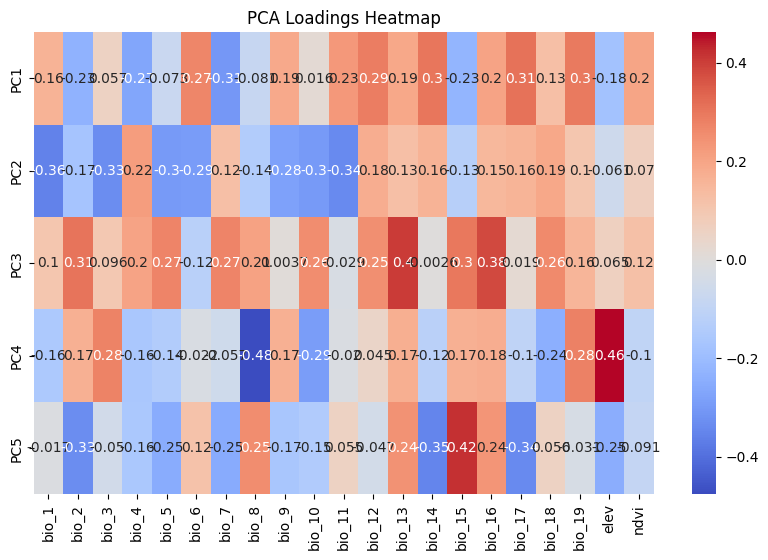

In [37]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=5) 
pca_result = pca.fit_transform(combined_filtered) 
loadings = pca.components_
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())
loadings_df = pd.DataFrame(loadings, columns=combined_scaled.columns, index=[f'PC{i+1}' for i in range(loadings.shape[0])])
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm')
plt.title('PCA Loadings Heatmap')

In [38]:
n_components = pca_result.shape[1]

for i in range(n_components):
    combined_filtered[f'PC{i+1}'] = pca_result[:, i]



In [39]:
osmia_pca = pca.transform(osmia_scaled)
for i in range(n_components):
    osmia_scaled[f'PC{i+1}'] = osmia_pca[:, i]

In [40]:
combined_filtered['group'] = combined_clipped['group']
osmia_scaled['group'] = 'osmia'

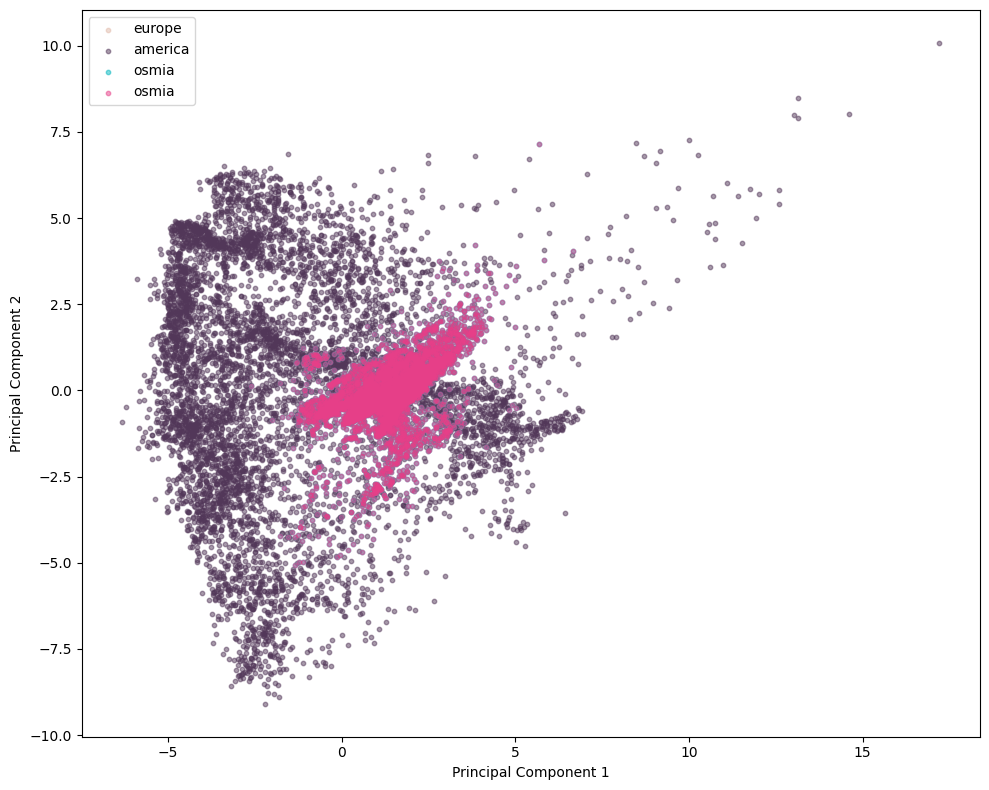

In [41]:
colors = ['#E1BAAA', '#523759', '#00B6BE','#E73F88']

plt.figure(figsize=(10, 8))

unique_labels = combined['group'].unique()  
for i, label in enumerate(unique_labels):
    subset = combined_filtered[combined_filtered['group'] == label]  
    plt.scatter(subset['PC1'], subset['PC2'], c=colors[i], label=label, s=10, marker= 'o', alpha=0.5)
plt.scatter(osmia_scaled['PC1'], osmia_scaled['PC2'], c=colors[i+1], label=label, s=10, marker= 'o', alpha=0.5)
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()

In [42]:
osmia_scaled[osmia_scaled['PC1']<-6]

,bio_1,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9,bio_10,...,bio_18,bio_19,elev,ndvi,PC1,PC2,PC3,PC4,PC5,group


In [43]:
# osmia_scaled.reset_index(inplace=True)
# osmia_scaled[osmia_scaled['PC1']<-6]

In [44]:
# osmia_coords.iloc[3666]

In [45]:
# osmia_coords.iloc[3666]['lat']
# plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
# ax = plt.gca()
# ax.set_extent([-11, 53, 34,  66]) 

# ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
# ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
# ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
# ax.add_feature(lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

# ax.scatter(osmia_coords.iloc[3666]['lon'], osmia_coords.iloc[3666]['lat'], transform=ccrs.PlateCarree(), marker='o', color='red', s=3)
# ax.axis('off')

In [46]:
osmia_pca_df = osmia_scaled.iloc[:, -6:-1].reset_index(drop=True)
america_pca_df = combined_filtered[combined_filtered['group'] == 'america']
america_pca_df = america_pca_df.iloc[:, -6:-1].reset_index(drop=True)
europe_pca_df = combined_filtered[combined_filtered['group'] == 'europe']
europe_pca_df = europe_pca_df.iloc[:, -6:-1].reset_index(drop=True)


In [47]:
from scipy.spatial import distance
from scipy.stats import chi2

osmia_mean = osmia_pca_df.mean()
osmia_cov = osmia_pca_df.cov()

def mahalanobis_distance(x, mean, cov):
    x_minus_mu = x - mean
    cov_inv = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, cov_inv)
    mahal = np.dot(left_term, x_minus_mu.T)
    return np.sqrt(mahal)

mahal_distances = america_pca_df.apply(lambda x: mahalanobis_distance(x, osmia_mean, osmia_cov), axis=1)

In [48]:
mahal_distances_eur = osmia_pca_df.apply(lambda x: mahalanobis_distance(x, osmia_mean, osmia_cov), axis=1)

Text(0.5, 1.0, 'distribution of mahal distances, america to eur')

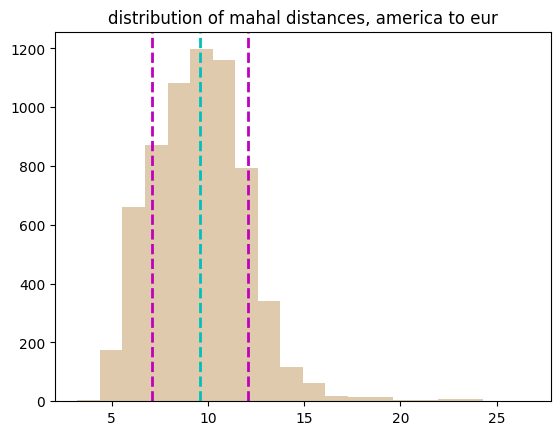

In [49]:
mean = np.mean(mahal_distances)
std_dev = np.std(mahal_distances)

# Create histogram
plt.hist(mahal_distances, bins=20, alpha=0.7, color='tan')

# Mark the mean
plt.axvline(mean, color='c', linestyle='dashed', linewidth=2, label='Mean')

# Mark one standard deviation on either side of the mean
plt.axvline(mean + std_dev, color='m', linestyle='dashed', linewidth=2, label='+1 STD')
plt.axvline(mean - std_dev, color='m', linestyle='dashed', linewidth=2, label='-1 STD')
plt.title('distribution of mahal distances, america to eur')

Text(0.5, 1.0, 'distribution of mahal distances, eur to eur')

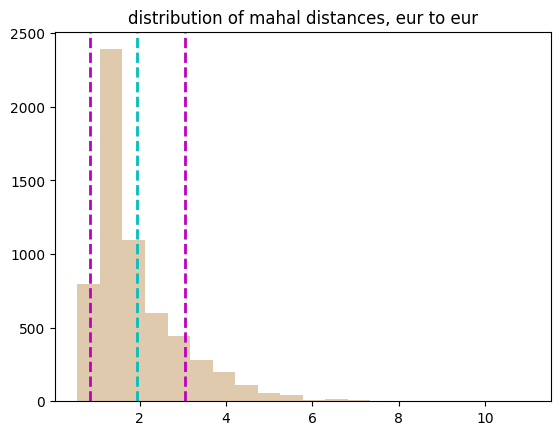

In [50]:
mean = np.mean(mahal_distances_eur)
std_dev = np.std(mahal_distances_eur)
# z = 1.96
# upper_bound = mean + z * std_dev

plt.hist(mahal_distances_eur, bins=20, alpha=0.7, color='tan')

# Mark the mean
plt.axvline(mean, color='c', linestyle='dashed', linewidth=2, label='Mean')

# Mark one standard deviation on either side of the mean
plt.axvline(mean + std_dev, color='m', linestyle='dashed', linewidth=2, label='+1 STD')
plt.axvline(mean - std_dev, color='m', linestyle='dashed', linewidth=2, label='-1 STD')
# plt.axvline(upper_bound, color='k', linestyle='dashed', linewidth=2, label='-1 STD')
plt.title('distribution of mahal distances, eur to eur')

In [51]:
print('Euro range of distances:', mahal_distances_eur.min(), mahal_distances_eur.max())

Euro range of distances: 0.5598734901320548 10.999997756180136


In [52]:
america_points['dist'] = mahal_distances


In [53]:
mahal_distances_eur = mahal_distances_eur.reset_index(drop=True)

crta_coords_filtered['dist'] = mahal_distances_eur

(-14641852.624039328, -6841695.90415462, 2746944.401339209, 7307496.882081329)

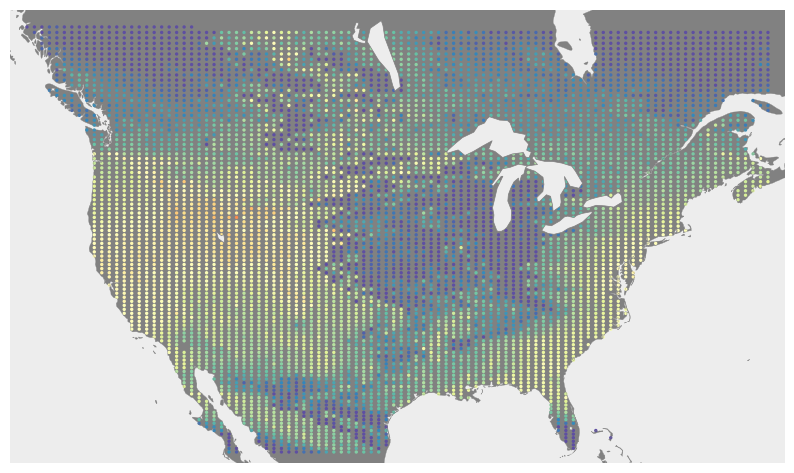

In [54]:
import geopandas as gpd
from shapely.geometry import Point
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt

extent = [-131.53, -61.46, 24.09, 54.90]

map_projection = ccrs.Mercator() 

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

shapefile_path = 'data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': map_projection})
ax.set_extent(extent, crs=ccrs.PlateCarree())  # Adjust as needed

ax.add_feature(cfeature.LAND, facecolor='#818181', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')


ax.scatter(america_points['lon'], america_points['lat'], transform=ccrs.PlateCarree(), 
           c=america_points['dist'], cmap='Spectral', vmin=0.25, vmax = 12.2, s=2)

ax.axis('off')
